In [1]:
from pathlib import Path
import os, json, re, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from joblib import dump, load

# sklearn
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    classification_report,
    confusion_matrix,
    roc_auc_score,   
)

# Reproducibility
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# --- Dataset paths ---
LIAR_DIR = Path("data/LIAR_dataset")
NEWS_DIR = Path("data/News_dataset")

print("LIAR dataset path:", LIAR_DIR)
print("News dataset path:", NEWS_DIR)

# --- LIAR split files ---
train_file = LIAR_DIR / "train.tsv"
val_file   = LIAR_DIR / "valid.tsv"
test_file  = LIAR_DIR / "test.tsv"

for f in [train_file, val_file, test_file]:
    assert f.exists(), f"Missing file: {f}"

# --- LIAR loading function ---
def load_liar(path: Path) -> pd.DataFrame:
    """
    Load the LIAR dataset (Kaggle format: first column = id, second = label).
    The file is tab-separated with 14 columns and no header.
    """
    df = pd.read_csv(path, sep="\t", header=None, dtype=str, keep_default_na=False)
    df = df.rename(columns={
        0:"id", 1:"label", 2:"statement", 3:"subject", 4:"speaker", 5:"job_title",
        6:"state_info", 7:"party_affiliation", 8:"barely_true_counts", 9:"false_counts",
        10:"half_true_counts", 11:"mostly_true_counts", 12:"pants_on_fire_counts",
        13:"context"
    })
    return df

# --- Load LIAR splits ---
train_df = load_liar(train_file)
val_df   = load_liar(val_file)
test_df  = load_liar(test_file)

# --- Label mapping (text → numeric id) ---
label_map = {
    "pants-fire": 0,
    "false": 1,
    "barely-true": 2,
    "half-true": 3,
    "mostly-true": 4,
    "true": 5
}

for df in (train_df, val_df, test_df):
    df["label_id"] = df["label"].map(label_map)

print("Shapes → Train:", train_df.shape, " Val:", val_df.shape, " Test:", test_df.shape)
train_df.head(3)


LIAR dataset path: data\LIAR_dataset
News dataset path: data\News_dataset
Shapes → Train: (10240, 15)  Val: (1284, 15)  Test: (1267, 15)


,id,label,statement,subject,speaker,job_title,state_info,party_affiliation,barely_true_counts,false_counts,half_true_counts,mostly_true_counts,pants_on_fire_counts,context,label_id
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0,1,0,0,0,a mailer,1
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0,0,1,1,0,a floor speech.,3
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70,71,160,163,9,Denver,4


Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best params: {'clf__C': 0.5}
Test macro-F1: 0.2418

Classification report (test):
               precision    recall  f1-score   support

           0     0.1634    0.3587    0.2245        92
           1     0.3238    0.2731    0.2963       249
           2     0.2368    0.2123    0.2239       212
           3     0.2704    0.2000    0.2299       265
           4     0.2168    0.2033    0.2099       241
           5     0.2469    0.2885    0.2661       208

    accuracy                         0.2431      1267
   macro avg     0.2430    0.2560    0.2418      1267
weighted avg     0.2535    0.2431    0.2437      1267



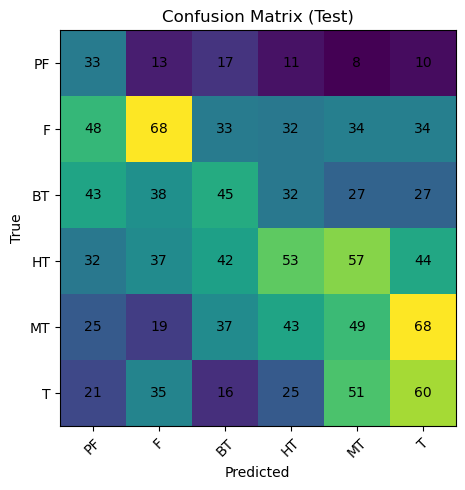

In [2]:
# Features/labels
X_train, y_train = train_df["statement"].tolist(), train_df["label_id"].astype(int).to_numpy()
X_val,   y_val   = val_df["statement"].tolist(),   val_df["label_id"].astype(int).to_numpy()
X_test,  y_test  = test_df["statement"].tolist(),  test_df["label_id"].astype(int).to_numpy()

# TF-IDF + Logistic Regression (simple, reproducible)
pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("clf", LogisticRegression(max_iter=3000, random_state=42, class_weight="balanced"))
])

grid = GridSearchCV(
    pipe,
    param_grid={"clf__C": [0.5, 1.0, 2.0]},
    scoring="f1_macro",
    cv=3,
    n_jobs=-1,
    verbose=1
)
grid.fit(X_train, y_train)

y_test_pred = grid.predict(X_test)
test_f1 = f1_score(y_test, y_test_pred, average="macro")
print("Best params:", grid.best_params_)
print("Test macro-F1:", round(test_f1, 4))
print("\nClassification report (test):\n", classification_report(y_test, y_test_pred, digits=4))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
ticks = ["PF","F","BT","HT","MT","T"]
plt.xticks(range(6), ticks, rotation=45); plt.yticks(range(6), ticks)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


In [3]:
os.makedirs("experiments", exist_ok=True)

dump(grid.best_estimator_, "experiments/liar_logreg_model.joblib")
with open("experiments/liar_logreg_metrics.json", "w") as f:
    json.dump({
        "model": "TFIDF(word 1-2) + LogReg",
        "best_params": grid.best_params_,
        "test_macro_f1": float(test_f1)
    }, f, indent=2)


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Char-only best: {'clf__C': 0.25, 'clf__class_weight': 'balanced', 'clf__loss': 'squared_hinge', 'tfidf__ngram_range': (3, 6)}  Test macro-F1: 0.2383
Char-only — Test accuracy: 0.2463 | Test macro-F1: 0.2383

Classification report (char-only):
               precision    recall  f1-score   support

           0     0.1440    0.1957    0.1659        92
           1     0.2928    0.2610    0.2760       249
           2     0.2222    0.1981    0.2095       212
           3     0.2530    0.2377    0.2451       265
           4     0.2576    0.2448    0.2511       241
           5     0.2569    0.3125    0.2820       208

    accuracy                         0.2463      1267
   macro avg     0.2378    0.2416    0.2383      1267
weighted avg     0.2493    0.2463    0.2467      1267



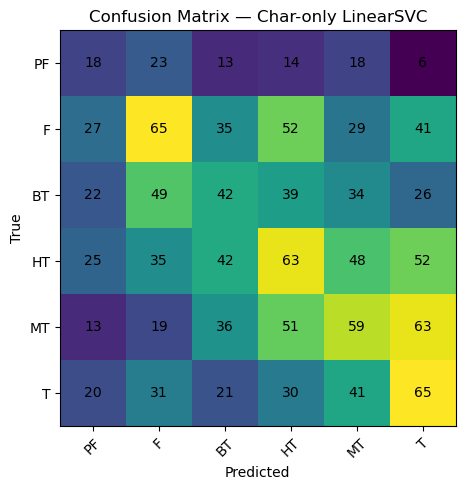

In [4]:
# TF-IDF(char 3-6) + LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score

pipe_char = Pipeline([
    ("tfidf", TfidfVectorizer(analyzer="char", ngram_range=(3,6),
                              min_df=1, max_df=0.95, sublinear_tf=True)),
    ("clf", LinearSVC(random_state=SEED))
])

param_grid_char = {
    "tfidf__ngram_range": [(3,5), (3,6), (4,6)],
    "clf__C": [0.25, 0.5, 1, 2, 4],
    "clf__class_weight": [None, "balanced"],
    "clf__loss": ["squared_hinge", "hinge"],
}

grid_char = GridSearchCV(pipe_char, param_grid_char,
                         scoring="f1_macro", cv=5, n_jobs=-1, verbose=1)
grid_char.fit(X_train, y_train)
y_test_pred_char = grid_char.predict(X_test)
char_f1 = f1_score(y_test, y_test_pred_char, average="macro")
print("Char-only best:", grid_char.best_params_, " Test macro-F1:", round(char_f1, 4))


os.makedirs("experiments", exist_ok=True)

# Evaluate
test_acc_char = accuracy_score(y_test, y_test_pred_char)
print(f"Char-only — Test accuracy: {test_acc_char:.4f} | Test macro-F1: {char_f1:.4f}")
print("\nClassification report (char-only):\n",
      classification_report(y_test, y_test_pred_char, digits=4))

# Confusion matrix
cm_char = confusion_matrix(y_test, y_test_pred_char)
plt.figure(figsize=(6,5))
plt.imshow(cm_char)
plt.title("Confusion Matrix — Char-only LinearSVC")
plt.xlabel("Predicted"); plt.ylabel("True")
ticks = ["PF","F","BT","HT","MT","T"]
plt.xticks(range(6), ticks, rotation=45); plt.yticks(range(6), ticks)
for i in range(cm_char.shape[0]):
    for j in range(cm_char.shape[1]):
        plt.text(j, i, cm_char[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()

# Save model + metrics
dump(grid_char.best_estimator_, "experiments/liar_char_svm_model.joblib")
with open("experiments/liar_char_svm_metrics.json", "w") as f:
    json.dump({
        "model": "TFIDF(char 3-6) + LinearSVC",
        "best_params": grid_char.best_params_,
        "test_macro_f1": float(char_f1),
        "test_accuracy": float(test_acc_char)
    }, f, indent=2)


Fitting 5 folds for each of 24 candidates, totalling 120 fits
Word+Char+SGD best: {'clf__alpha': 0.001, 'clf__penalty': 'l2', 'vec__char__ngram_range': (3, 6), 'vec__word__ngram_range': (1, 2)}  Test macro-F1: 0.2362
Word+Char+SGD — Test accuracy: 0.2478 | Test macro-F1: 0.2362

Classification report (word+char+SGD):
               precision    recall  f1-score   support

           0     0.1757    0.1413    0.1566        92
           1     0.2863    0.2771    0.2816       249
           2     0.2590    0.2028    0.2275       212
           3     0.2492    0.2792    0.2633       265
           4     0.2374    0.2739    0.2543       241
           5     0.2322    0.2356    0.2339       208

    accuracy                         0.2478      1267
   macro avg     0.2400    0.2350    0.2362      1267
weighted avg     0.2478    0.2478    0.2466      1267



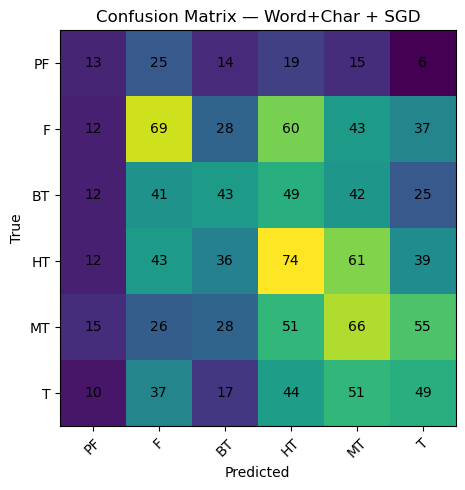

In [5]:
# Word + Char n-grams with SGDClassifier

word_v = TfidfVectorizer(analyzer="word", ngram_range=(1,2),
                         min_df=1, max_df=0.95, sublinear_tf=True)
char_v = TfidfVectorizer(analyzer="char", ngram_range=(3,6),
                         min_df=1, max_df=0.95, sublinear_tf=True)

pipe_wchar_sgd = Pipeline([
    ("vec", FeatureUnion([("word", word_v), ("char", char_v)])),
    ("clf", SGDClassifier(loss="hinge", random_state=SEED))
])

param_grid_wchar_sgd = {
    "vec__word__ngram_range": [(1,1), (1,2)],
    "vec__char__ngram_range": [(3,5), (3,6)],
    "clf__alpha": [1e-5, 1e-4, 1e-3],
    "clf__penalty": ["l2", "elasticnet"],
}

grid_wchar_sgd = GridSearchCV(
    pipe_wchar_sgd, param_grid_wchar_sgd,
    scoring="f1_macro", cv=5, n_jobs=-1, verbose=1
)
grid_wchar_sgd.fit(X_train, y_train)

y_test_pred_wchar_sgd = grid_wchar_sgd.predict(X_test)
wchar_sgd_f1 = f1_score(y_test, y_test_pred_wchar_sgd, average="macro")
print("Word+Char+SGD best:", grid_wchar_sgd.best_params_,
      " Test macro-F1:", round(wchar_sgd_f1, 4))

# --- Evaluate ---
test_acc_wchar_sgd = accuracy_score(y_test, y_test_pred_wchar_sgd)
print(f"Word+Char+SGD — Test accuracy: {test_acc_wchar_sgd:.4f} | Test macro-F1: {wchar_sgd_f1:.4f}")
print("\nClassification report (word+char+SGD):\n",
      classification_report(y_test, y_test_pred_wchar_sgd, digits=4))

# --- Confusion matrix ---
cm_wchar_sgd = confusion_matrix(y_test, y_test_pred_wchar_sgd)
plt.figure(figsize=(6,5))
plt.imshow(cm_wchar_sgd)  # default colormap; no custom colors
plt.title("Confusion Matrix — Word+Char + SGD")
plt.xlabel("Predicted"); plt.ylabel("True")
ticks = ["PF","F","BT","HT","MT","T"]
plt.xticks(range(6), ticks, rotation=45); plt.yticks(range(6), ticks)
for i in range(cm_wchar_sgd.shape[0]):
    for j in range(cm_wchar_sgd.shape[1]):
        plt.text(j, i, cm_wchar_sgd[i, j], ha="center", va="center")
plt.tight_layout(); plt.show()


os.makedirs("experiments", exist_ok=True)
dump(grid_wchar_sgd.best_estimator_, "experiments/liar_wordchar_sgd_model.joblib")
with open("experiments/liar_wordchar_sgd_metrics.json", "w") as f:
    json.dump({
        "model": "TFIDF(word 1-2 + char 3-6) + SGD(hinge)",
        "best_params": grid_wchar_sgd.best_params_,
        "test_macro_f1": float(wchar_sgd_f1),
        "test_accuracy": float(test_acc_wchar_sgd)
    }, f, indent=2)


In [6]:
# The next two cells are addressing the project proposal's feedback


# === Robustness check: Drop the last sentence from every claim (train and test) ===
# Idea: Some LIAR examples (e.g., “never…”) get their label from a dramatic final line.
# We remove the final sentence from ALL statements (both training and testing) and
# re-train/evaluate the baseline to see how much performance drops.
# Interpretation:
#   - Tiny Δ macro-F1 → model is NOT overly reliant on last-sentence cues.
#   - Large Δ → model depends heavily on the final sentence wording.
# This directly answers the feedback about task reasonableness and shortcut learning.

import re
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

def drop_last_sentence(text: str) -> str:
    parts = re.split(r'([.!?])', text)
    if len(parts) >= 2: parts = parts[:-2]
    return "".join(parts).strip() if parts else text

X_train_drop = [drop_last_sentence(t) for t in train_df["statement"]]
X_test_drop  = [drop_last_sentence(t) for t in test_df["statement"]]

pipe_ab = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("clf", LogisticRegression(max_iter=3000, random_state=SEED, class_weight="balanced", C=0.5))
])
pipe_ab.fit(X_train_drop, y_train)
ab_pred = pipe_ab.predict(X_test_drop)
ab_f1 = f1_score(y_test, ab_pred, average="macro")
print("Drop-last-sentence — Test macro-F1:", round(ab_f1, 4), " (baseline:", round(test_f1, 4), ")")


Drop-last-sentence — Test macro-F1: 0.2379  (baseline: 0.2418 )


In [7]:
# === Artifact check: metadata-only baseline (no statement text) ===
# Idea: If this scores non-trivially, models can exploit speaker/party/state shortcuts.

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix
from joblib import dump
import os, json

META_COLS = ["speaker","party_affiliation","state_info","subject","job_title","context"]

def meta_text(df):
    return (df[META_COLS].fillna("").astype(str).agg(" ".join, axis=1)).tolist()

Xm_train, Xm_test = meta_text(train_df), meta_text(test_df)

meta_pipe = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, sublinear_tf=True)),
    ("clf", LogisticRegression(max_iter=3000, random_state=SEED, class_weight="balanced", C=1.0))
])

meta_pipe.fit(Xm_train, y_train)
meta_pred = meta_pipe.predict(Xm_test)
meta_f1 = f1_score(y_test, meta_pred, average="macro")
meta_acc = accuracy_score(y_test, meta_pred)
print(f"Metadata-only — Test accuracy: {meta_acc:.4f} | Test macro-F1: {meta_f1:.4f}")
print("\nClassification report (metadata-only):\n", classification_report(y_test, meta_pred, digits=4))

# Save
os.makedirs("experiments", exist_ok=True)
dump(meta_pipe, "experiments/liar_metadata_only_model.joblib")
with open("experiments/liar_metadata_only_metrics.json","w") as f:
    json.dump({"model":"metadata_only","macro_f1":float(meta_f1),"accuracy":float(meta_acc)}, f, indent=2)


Metadata-only — Test accuracy: 0.2518 | Test macro-F1: 0.2541

Classification report (metadata-only):
               precision    recall  f1-score   support

           0     0.2387    0.4022    0.2996        92
           1     0.2632    0.2209    0.2402       249
           2     0.2128    0.1887    0.2000       212
           3     0.2836    0.2151    0.2446       265
           4     0.2870    0.2573    0.2713       241
           5     0.2282    0.3269    0.2688       208

    accuracy                         0.2518      1267
   macro avg     0.2522    0.2685    0.2541      1267
weighted avg     0.2560    0.2518    0.2493      1267



In [8]:
# Summary 

rows = [
    ("TFIDF(word 1-2) + LogReg", float(test_f1), float(accuracy_score(y_test, y_test_pred))),
    ("TFIDF(char 3-6) + LinearSVC", float(char_f1), float(accuracy_score(y_test, y_test_pred_char))),
    ("TFIDF(word 1-2 + char 3-6) + SGD(hinge)", float(wchar_sgd_f1), float(accuracy_score(y_test, y_test_pred_wchar_sgd))),
    ("Metadata-only", float(meta_f1), float(meta_acc)),
]
summary = pd.DataFrame(rows, columns=["model","macro_f1","accuracy"]).sort_values("macro_f1", ascending=False)
display(summary)

os.makedirs("experiments", exist_ok=True)
summary.to_csv("experiments/liar_models_summary.csv", index=False)

best_model_name = summary.iloc[0]["model"]
best_preds = {
    "TFIDF(word 1-2) + LogReg": y_test_pred,
    "TFIDF(char 3-6) + LinearSVC": y_test_pred_char,
    "TFIDF(word 1-2 + char 3-6) + SGD(hinge)": y_test_pred_wchar_sgd,
    "Metadata-only": meta_pred,
}[best_model_name]
print("Best by macro-F1:", best_model_name)

os.makedirs("experiments", exist_ok=True)

with open("experiments/label_map.json", "w") as f:
    json.dump(label_map, f, indent=2)

liar_stats = {
    "train_shape": list(train_df.shape),
    "val_shape": list(val_df.shape),
    "test_shape": list(test_df.shape),
    "train_label_counts": train_df["label"].value_counts().to_dict(),
    "val_label_counts": val_df["label"].value_counts().to_dict(),
    "test_label_counts": test_df["label"].value_counts().to_dict(),
}
with open("experiments/liar_dataset_stats.json","w") as f:
    json.dump(liar_stats, f, indent=2)


,model,macro_f1,accuracy
3,Metadata-only,0.254086,0.251776
0,TFIDF(word 1-2) + LogReg,0.241755,0.243094
1,TFIDF(char 3-6) + LinearSVC,0.238263,0.246251
2,TFIDF(word 1-2 + char 3-6) + SGD(hinge),0.236224,0.247830


Best by macro-F1: Metadata-only


In [11]:
pip install --upgrade --force-reinstall "pyarrow>=14,<17" "datasets[parquet]"


     ---------------------------------------- 0.0/1.1 MB ? eta -:--:--
     ---------------------------------------- 1.1/1.1 MB 11.9 MB/s  0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached datasets-4.1.1-py3-none-any.whl.metadata (18 kB)
  Using cached numpy-2.3.3-cp313-cp313-win_amd64.whl.metadata (60 kB)
INFO: pip is looking at multiple versions of datasets[parquet] to determine which version is compatible with other requirements. This could take a while.
  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
  Using cached xxhash-3.6.0-cp313-cp313-win_amd64.whl.metadata (13 kB)
  Using cached multiprocess-0.70.16-py312-none-any.whl.metadata (7.2 kB)
  Using cached huggingface_hub

  error: subprocess-exited-with-error
  
  exit code: 1
  
  [358 lines of output]
  <string>:34: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  C:\Users\Admin\AppData\Local\Temp\pip-build-env-dhsw8sfw\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'tests_require'
    warnings.warn(msg)
  C:\Users\Admin\AppData\Local\Temp\pip-build-env-dhsw8sfw\overlay\Lib\site-packages\setuptools\_distutils\dist.py:289: UserWarning: Unknown distribution option: 'test_suite'
    warnings.warn(msg)
  toml section missing WindowsPath('pyproject.toml') does not contain a tool.setuptools_scm section
  toml section missing WindowsPath('pyproject.toml') does not contain a tool.setuptools_scm section
  C:\Users\Admin\AppData\Local\Temp\pip-build-env-dhsw8sfw\ov

Using device: cpu


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

D:\anaconda_main\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Admin\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1 | Step 50/1280 | Loss 1.7946
Epoch 1 | Step 100/1280 | Loss 1.7890
Epoch 1 | Step 150/1280 | Loss 1.7810
Epoch 1 | Step 200/1280 | Loss 1.7749
Epoch 1 | Step 250/1280 | Loss 1.7684
Epoch 1 | Step 300/1280 | Loss 1.7662
Epoch 1 | Step 350/1280 | Loss 1.7653
Epoch 1 | Step 400/1280 | Loss 1.7617
Epoch 1 | Step 450/1280 | Loss 1.7569
Epoch 1 | Step 500/1280 | Loss 1.7514
Epoch 1 | Step 550/1280 | Loss 1.7519
Epoch 1 | Step 600/1280 | Loss 1.7492
Epoch 1 | Step 650/1280 | Loss 1.7462
Epoch 1 | Step 700/1280 | Loss 1.7435
Epoch 1 | Step 750/1280 | Loss 1.7406
Epoch 1 | Step 800/1280 | Loss 1.7382
Epoch 1 | Step 850/1280 | Loss 1.7364
Epoch 1 | Step 900/1280 | Loss 1.7334
Epoch 1 | Step 950/1280 | Loss 1.7309
Epoch 1 | Step 1000/1280 | Loss 1.7294
Epoch 1 | Step 1050/1280 | Loss 1.7278
Epoch 1 | Step 1100/1280 | Loss 1.7268
Epoch 1 | Step 1150/1280 | Loss 1.7262
Epoch 1 | Step 1200/1280 | Loss 1.7247
Epoch 1 | Step 1250/1280 | Loss 1.7244
Epoch 1 | Step 1280/1280 | Loss 1.7249
Epoch 

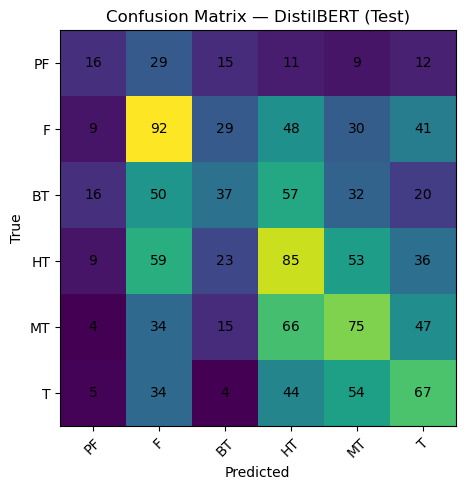

Saved model/tokenizer to experiments/bert_liar_plain\model and metrics.json


In [17]:
# === DistilBERT fine-tuning on LIAR (plain PyTorch, no HF datasets, no Trainer) ===
# - No 'datasets' import -> no pyarrow/parquet dependency
# - Tokenization happens in the DataLoader collate_fn (dynamic padding)
# - Works on CPU or GPU (auto-detect); tweak batch size if OOM

# If transformers is missing, install once in a terminal: pip install transformers accelerate
import os, json, math, numpy as np, torch, matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

# --- Reproducibility ---
torch.manual_seed(SEED)
np.random.seed(SEED)

# --- Config ---
MODEL_NAME   = "distilbert-base-uncased"
MAX_LEN      = 128             # keep modest for stability/CPU
EPOCHS       = 3               # try 2–4
LR           = 2e-5
WARMUP_RATIO = 0.1
BATCH_TRAIN  = 16 if torch.cuda.is_available() else 8
BATCH_EVAL   = 32 if torch.cuda.is_available() else 16
OUT_DIR      = "experiments/bert_liar_plain"
FIG_DIR      = "figures"

os.makedirs(OUT_DIR, exist_ok=True)
os.makedirs(FIG_DIR, exist_ok=True)

# --- Device ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- Simple torch Dataset that yields raw text + label ---
class TextLabelDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts  = list(texts)
        self.labels = np.asarray(labels, dtype=int)
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return self.texts[idx], int(self.labels[idx])

# Build datasets from your dataframes
train_ds = TextLabelDataset(train_df["statement"], train_df["label_id"])
val_ds   = TextLabelDataset(val_df["statement"],   val_df["label_id"])
test_ds  = TextLabelDataset(test_df["statement"],  test_df["label_id"])

# --- Tokenizer + collate function (tokenize & pad per batch) ---
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def collate_fn(batch):
    texts  = [b[0] for b in batch]
    labels = torch.tensor([b[1] for b in batch], dtype=torch.long)
    enc = tokenizer(
        texts,
        padding=True, truncation=True, max_length=MAX_LEN,
        return_tensors="pt"
    )
    enc["labels"] = labels
    return enc

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True,  collate_fn=collate_fn)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_EVAL,  shuffle=False, collate_fn=collate_fn)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_EVAL,  shuffle=False, collate_fn=collate_fn)

# --- Model ---
id2label = {0:"pants-fire",1:"false",2:"barely-true",3:"half-true",4:"mostly-true",5:"true"}
label2id = {v:k for k,v in id2label.items()}

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=6, id2label=id2label, label2id=label2id
).to(device)

# --- Optimizer + Scheduler ---
optimizer = torch.optim.AdamW(model.parameters(), lr=LR)
total_steps = EPOCHS * len(train_loader)
warmup_steps = int(WARMUP_RATIO * total_steps)
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# --- Helpers ---
def evaluate(model, loader):
    model.eval()
    all_preds, all_labels = [], []
    total_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            out = model(**batch)
            loss = out.loss
            logits = out.logits
            total_loss += float(loss.item()) * batch["labels"].size(0)
            preds = logits.argmax(dim=-1).detach().cpu().numpy()
            labels = batch["labels"].detach().cpu().numpy()
            all_preds.append(preds)
            all_labels.append(labels)
    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)
    macro_f1 = f1_score(all_labels, all_preds, average="macro")
    acc = accuracy_score(all_labels, all_preds)
    return macro_f1, acc, total_loss / len(loader.dataset), all_labels, all_preds

# --- Training loop with simple early stopping on val macro-F1 ---
best_val_f1 = -1.0
best_state  = None

for epoch in range(1, EPOCHS+1):
    model.train()
    running_loss = 0.0
    for step, batch in enumerate(train_loader, start=1):
        batch = {k: v.to(device) for k, v in batch.items()}
        out = model(**batch)
        loss = out.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()
        running_loss += float(loss.item())

        if step % 50 == 0 or step == len(train_loader):
            print(f"Epoch {epoch} | Step {step}/{len(train_loader)} | Loss {running_loss/step:.4f}")

    # Validation each epoch
    val_f1, val_acc, val_loss, _, _ = evaluate(model, val_loader)
    print(f"Epoch {epoch} done. Val macro-F1: {val_f1:.4f} | Val acc: {val_acc:.4f} | Val loss: {val_loss:.4f}")

    # Track best
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        best_state  = {k: v.cpu().clone() for k, v in model.state_dict().items()}

# Load best validation state (if any)
if best_state is not None:
    model.load_state_dict(best_state)
    print(f"Loaded best checkpoint by val macro-F1 = {best_val_f1:.4f}")

# --- Test evaluation ---
test_f1, test_acc, test_loss, y_true, y_pred = evaluate(model, test_loader)
print(f"\nDistilBERT (plain) — Test macro-F1: {test_f1:.4f} | Test accuracy: {test_acc:.4f} | Test loss: {test_loss:.4f}")
print("\nClassification report (test):\n",
      classification_report(y_true, y_pred, digits=4, target_names=[id2label[i] for i in range(6)]))

# --- Confusion matrix figure ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,5))
plt.imshow(cm)
plt.title("Confusion Matrix — DistilBERT (Test)")
plt.xlabel("Predicted"); plt.ylabel("True")
ticks = ["PF","F","BT","HT","MT","T"]
plt.xticks(range(6), ticks, rotation=45); plt.yticks(range(6), ticks)
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(j, i, cm[i, j], ha="center", va="center")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "liar_confusion_matrix_distilbert_plain.png"), dpi=200)
plt.show()

# --- Save model + tokenizer + metrics ---
model.save_pretrained(os.path.join(OUT_DIR, "model"))
tokenizer.save_pretrained(os.path.join(OUT_DIR, "model"))
with open(os.path.join(OUT_DIR, "metrics.json"), "w") as f:
    json.dump({
        "macro_f1": float(test_f1),
        "accuracy": float(test_acc),
        "val_best_macro_f1": float(best_val_f1),
        "model_name": MODEL_NAME,
        "max_len": MAX_LEN,
        "epochs": EPOCHS,
        "lr": LR,
        "batch_train": BATCH_TRAIN,
        "batch_eval": BATCH_EVAL
    }, f, indent=2)

print("Saved model/tokenizer to", os.path.join(OUT_DIR, "model"), "and metrics.json")


Saved → experiments/bert_liar_plain/test_predictions.csv
Saved → experiments/bert_liar_plain/test_classification_report.csv


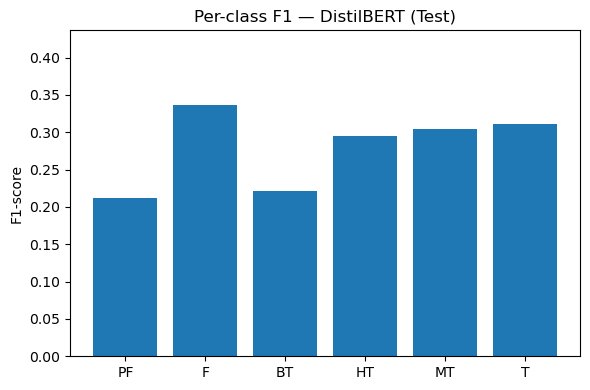

Saved → figures/liar_per_class_f1_distilbert.png


In [18]:
# Save predictions and per-class F1 chart for DistilBERT (plain loop result)
import os, json, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix

os.makedirs("experiments/bert_liar_plain", exist_ok=True)
os.makedirs("figures", exist_ok=True)

# y_true, y_pred should still be in memory from the training cell. If not, re-run the last eval part to get them again.

pred_df = pd.DataFrame({
    "id": test_df["id"],
    "statement": test_df["statement"],
    "true_label_id": test_df["label_id"],
    "true_label": test_df["label_id"].map({0:"pants-fire",1:"false",2:"barely-true",3:"half-true",4:"mostly-true",5:"true"}),
    "pred_label_id": y_pred,
    "pred_label": pd.Series(y_pred).map({0:"pants-fire",1:"false",2:"barely-true",3:"half-true",4:"mostly-true",5:"true"}),
})
pred_df.to_csv("experiments/bert_liar_plain/test_predictions.csv", index=False)
print("Saved → experiments/bert_liar_plain/test_predictions.csv")

rep = classification_report(
    pred_df["true_label_id"], pred_df["pred_label_id"],
    target_names=["pants-fire","false","barely-true","half-true","mostly-true","true"],
    output_dict=True, digits=4
)
pd.DataFrame(rep).to_csv("experiments/bert_liar_plain/test_classification_report.csv")
print("Saved → experiments/bert_liar_plain/test_classification_report.csv")

per_class_f1 = [rep[name]["f1-score"] for name in ["pants-fire","false","barely-true","half-true","mostly-true","true"]]
labels = ["PF","F","BT","HT","MT","T"]
plt.figure(figsize=(6,4))
plt.bar(labels, per_class_f1)
plt.title("Per-class F1 — DistilBERT (Test)")
plt.ylabel("F1-score"); plt.ylim(0, max(per_class_f1)+0.1)
plt.tight_layout()
plt.savefig("figures/liar_per_class_f1_distilbert.png", dpi=200)
plt.show()
print("Saved → figures/liar_per_class_f1_distilbert.png")


In [19]:
import os, json, pandas as pd

rows = []

def maybe_add(path, name, acc_key="test_accuracy", f1_key="test_macro_f1"):
    if os.path.exists(path):
        with open(path) as f:
            d = json.load(f)
        acc = d.get(acc_key, d.get("accuracy"))
        f1  = d.get(f1_key,  d.get("macro_f1"))
        rows.append((name, float(f1), float(acc) if acc is not None else None))
    else:
        print(f"(!) Missing: {path}")

maybe_add("experiments/liar_logreg_metrics.json",        "TFIDF(word 1–2) + LogReg")
maybe_add("experiments/liar_char_svm_metrics.json",      "TFIDF(char 3–6) + LinearSVC")
maybe_add("experiments/liar_wordchar_sgd_metrics.json",  "TFIDF(word+char) + SGD(hinge)")
maybe_add("experiments/liar_metadata_only_metrics.json", "Metadata-only")

with open("experiments/bert_liar_plain/metrics.json") as f:
    bm = json.load(f)
rows.append(("DistilBERT (text-only)", float(bm["macro_f1"]), float(bm["accuracy"])))

summary = pd.DataFrame(rows, columns=["model","macro_f1","accuracy"]).sort_values("macro_f1", ascending=False)
display(summary)
summary.to_csv("experiments/liar_models_summary_with_bert.csv", index=False)
print("Saved → experiments/liar_models_summary_with_bert.csv")


,model,macro_f1,accuracy
4,DistilBERT (text-only),0.279814,0.293607
3,Metadata-only,0.254086,0.251776
0,TFIDF(word 1–2) + LogReg,0.241755,NaN
1,TFIDF(char 3–6) + LinearSVC,0.238263,0.246251
2,TFIDF(word+char) + SGD(hinge),0.236224,0.247830


Saved → experiments/liar_models_summary_with_bert.csv
